In [2]:
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from helpers import vec

In [5]:
from Systems import AutoDiffSystemModel

# Kinematic Car Example With Non-Linear Drag and Turbulence
#  - state: {position, velocity}
#  - control: {acceleration}
#  - dynamics: f(x, u) = [
#       position + velocity*dt + (1/2)(acceleration + noise_accel)*dt^2,
#       velocity + (acceleration - sign(v) * drag)*dt
#   ] where
#       drag = drag_coeff1*velocity + (drag_coeff2 + noise_drag)*velocity^2
#  - measurement: h(x) = position + noise


dt = 0.1
drag_coeff1 = 0.0
drag_coeff2 = 0.4

def dynamics_func(x, u, w):
    pos, vel = x.flatten()
    acc = u.flatten()[0]
    noise_acc, noise_drag = w.flatten()
    drag = drag_coeff1*vel + (drag_coeff2 + noise_drag)*vel**2  # <-- non-linear dependence on v
    return jnp.array([
        [pos + vel*dt + 0.5*(acc + noise_acc)*dt**2],
        [vel + (acc - jnp.sign(vel)*drag)*dt]
    ])

def measurement_func(x, v):
    pos, vel = x.flatten()
    noise = v.flatten()[0]
    return jnp.array([
        [pos + noise]
    ])

# dynamics noise covariance
accel_noise_variance = 0.01
drag_noise_variance = 0.001
R = jnp.array([
    [accel_noise_variance, 0],
    [0, drag_noise_variance]
])

# measurement noise covariance
measurement_variance = 0.3
Q = jnp.array([
    [measurement_variance]
])

car_system_gt = AutoDiffSystemModel(2, 1, 1, dynamics_func, measurement_func, R, Q)

100%|██████████| 149/149 [00:00<00:00, 469.03it/s]


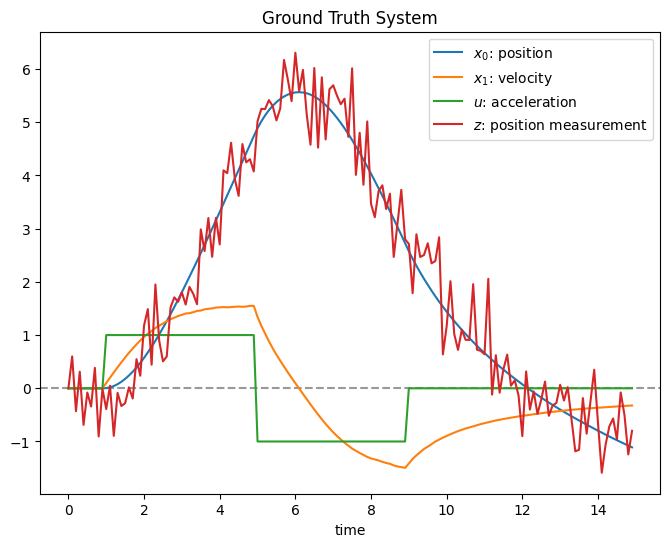

In [6]:
# Run the simulation

timesteps = np.arange(0.0, 15.0, step=dt)
T = len(timesteps)

states_gt = np.zeros((T, 2, 1))
controls = np.zeros((T, 1, 1))

# initial position and velocity
states_gt[0] = vec(0, 0)

measurements = np.zeros((T, 1, 1))

# acceleration schedule
controls[10:50] = vec(1.0)
controls[50:90] = vec(-1.0)

for t in tqdm(range(1, T)):
    x = states_gt[t-1]
    u = controls[t]

    x_next = car_system_gt.query_dynamics_model(x, u)
    states_gt[t] = x_next

    z = car_system_gt.query_measurement_model(x)
    measurements[t] = z

# Plot results
plt.figure(figsize=(8, 6))
plt.title("Ground Truth System")
plt.xlabel("time")
plt.axhline(0, linestyle="--", color="gray", alpha=0.8)
plt.plot(timesteps, states_gt[:,0], label="$x_0$: position")
plt.plot(timesteps, states_gt[:,1], label="$x_1$: velocity")
plt.plot(timesteps, controls[:,0], label="$u$: acceleration")
plt.plot(timesteps, measurements[:,0], label="$z$: position measurement")
plt.legend()

In [7]:
from Filters import ExtendedKalmanFilter

# Define the approximate system model to be used by the filter
# in this case, our model has no mismatch with ground-truth system
car_system_approx = deepcopy(car_system_gt)

car_filter = ExtendedKalmanFilter(car_system_approx)

100%|██████████| 149/149 [00:12<00:00, 12.02it/s]


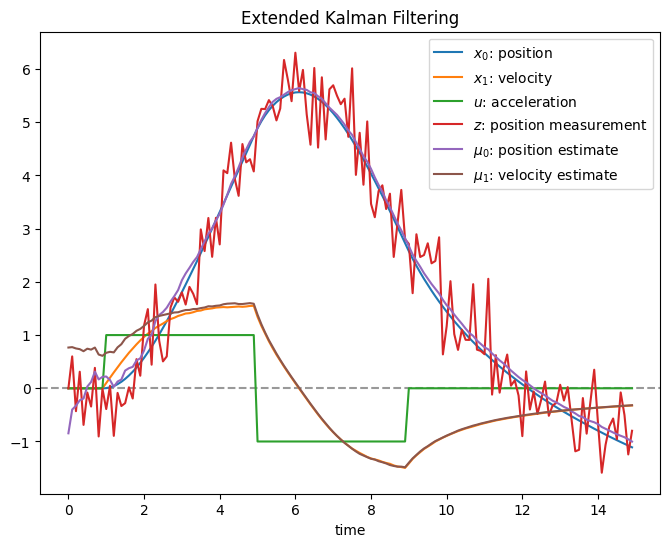

In [8]:
# Run the filter

# initial state belief
car_filter.initialize(
    vec(np.random.normal(0, 1), np.random.normal(0, 1)),      # initial mean
    np.array([      # initial covariance
        [0.1, 0.0],
        [0.0, 0.1]
    ])
)

means_EKF = np.zeros((T, 2, 1))
covariances_EKF = np.zeros((T, 2, 2))

means_EKF[0] = car_filter.mean
covariances_EKF[0] = car_filter.covariance


for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    car_filter.predict_step(u)
    car_filter.update_step(z)

    means_EKF[t] = car_filter.mean
    covariances_EKF[t] = car_filter.covariance


# Plot results
plt.figure(figsize=(8, 6))
plt.title("Extended Kalman Filtering")
plt.xlabel("time")
plt.axhline(0, linestyle="--", color="gray", alpha=0.8)
plt.plot(timesteps, states_gt[:,0], label="$x_0$: position")
plt.plot(timesteps, states_gt[:,1], label="$x_1$: velocity")
plt.plot(timesteps, controls[:,0], label="$u$: acceleration")
plt.plot(timesteps, measurements[:,0], label="$z$: position measurement")
plt.plot(timesteps, means_EKF[:,0], label="$\mu_0$: position estimate")
plt.plot(timesteps, means_EKF[:,1], label="$\mu_1$: velocity estimate")
plt.legend()

In [9]:
from Filters import UnscentedKalmanFilter

# Define the approximate system model to be used by the filter
# in this case, our model has no mismatch with ground-truth system
car_system_approx = deepcopy(car_system_gt)

car_filter = UnscentedKalmanFilter(car_system_approx)

In [39]:
# Run the filter

# initial state belief
car_filter.initialize(
    vec(np.random.normal(0, 1), np.random.normal(0, 1)),      # initial mean
    np.array([      # initial covariance
        [0.1, 0.0],
        [0.0, 0.1]
    ])
)

means_UKF = np.zeros((T, 2, 1))
covariances_UKF = np.zeros((T, 2, 2))

means_UKF[0] = car_filter.mean
covariances_UKF[0] = car_filter.covariance


for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    car_filter.predict_step(u)
    car_filter.update_step(z)

    means_UKF[t] = car_filter.mean
    covariances_UKF[t] = car_filter.covariance


# Plot results
plt.figure(figsize=(8, 6))
plt.title("Unscented Kalman Filtering")
plt.xlabel("time")
plt.axhline(0, linestyle="--", color="gray", alpha=0.8)
plt.plot(timesteps, states_gt[:,0], label="$x_0$: position")
plt.plot(timesteps, states_gt[:,1], label="$x_1$: velocity")
plt.plot(timesteps, controls[:,0], label="$u$: acceleration")
plt.plot(timesteps, measurements[:,0], label="$z$: position measurement")
plt.plot(timesteps, means_UKF[:,0], label="$\mu_0$: position estimate")
plt.plot(timesteps, means_UKF[:,1], label="$\mu_1$: velocity estimate")
plt.legend()

  4%|▍         | 6/149 [00:00<00:01, 78.89it/s]

(1, 7)
[[0.40100031 0.40100193 0.40100199]
 [0.40100193 3.40710548 3.52934594]
 [0.40100199 3.52934594 3.6565572 ]]
(1, 7)
[[0.37892822 0.37892822 0.37892822]
 [0.37892822 2.946702   3.0259666 ]
 [0.37892822 3.0259666  3.10767802]]
(1, 7)
[[0.36696513 0.36696483 0.36696485]
 [0.36696483 1.77227542 1.70271769]
 [0.36696485 1.70271769 1.63660282]]
(1, 7)
[[0.35949329 0.3594925  0.35949256]
 [0.3594925  1.5899862  1.49724333]
 [0.35949256 1.49724333 1.41149054]]
(1, 7)
[[0.35547733 0.35547733 0.35547733]
 [0.35547733 1.11119939 0.8787046 ]
 [0.35547733 0.8787046  0.71773587]]
(1, 7)
[[0.35252452 0.3525249  0.35252474]
 [0.3525249  0.96011374 0.70338322]
 [0.35252474 0.70338322 0.55513151]]
(1, 7)
[[0.34834111 0.34834111 0.34834111]
 [0.34834111 0.79335435 0.49194583]
 [0.34834111 0.49194583 0.39468201]]


LinAlgError: Singular matrix